## Tutorial: Modelling Information & Rumour Diffusion in Online Social Networks


The most retweeted tweet in the world has 5.19 Million retweets. The most liked photo on instagram has 52.2 million likes. The reach and expanse of social networks makes it possible for a piece of information, be it authentic or fake, to travel across the globe and reach millions of people in a matter of seconds. This leads us to the question- what makes a post go viral in an online social network platform? Why are some posts ignored while some make headlines? Starting with these questions, we are modelling information diffusion and rumour propagation in online social networks. 


Through this tutorial, we develope four-part ways to model and analyse the information spread process in online social networks. To validate our models, we run simulations on randomly generated graphs as well real world social networks. Further, we are also looking at how the network structure effects the process of information diffusion. A brief description of the sections are as follows:

**[Part 0 - CA Model](https://github.gatech.edu/ayousuf6/CSE6730-InformationDiffusion/blob/master/notebooks/Part-0-CA-Network.ipynb)**: This part models the spread of information and rumours in a network graph through the S-I-R model- cellular automata (CA) model. For simulating the results, we use a random Barabasi Albert social network graph.

**[Part 1 - Network Comparison](https://github.gatech.edu/ayousuf6/CSE6730-InformationDiffusion/blob/master/notebooks/Part-1-NetworkComparison.ipynb)**: In this part, we generate different social networks and study its structure characteristics. These networks are then used to study the CA model and the variations in results are analysed and discussed.

**[Part 2 - ODE Model](https://github.gatech.edu/ayousuf6/CSE6730-InformationDiffusion/blob/master/notebooks/Part-2-ODE-Model.ipynb)**: Given the dynamic nature of the population of real social networks,  we take into account the addition of new users and the creation of inactive users over time. For this, we have built a continuous time model considering population dynamics of a logistic equation based on the SIR model. Further, we simulate the results on real world Facebook dataset. 

**[Part 3 - Network Model with Echo Chambers](https://github.gatech.edu/ayousuf6/CSE6730-InformationDiffusion/blob/master/notebooks/Part-3-EchoChamberEffect.ipynb)**: In this section, we have created a network model to study the dynamics of the network structure and the impact it has on the spread of information/ rumours.  Specifically, we study the effect that online echo chambers have on the virality of an information. Online echo chambers are modelled as a set of users characterized by opinion and network polarization, i.e. they are clusters of like-minded users. The results are simulated on random Erdős–Rényi graphs to study how virality of an information is impacted with varying parameters and network structures.  



### Part 0: Cellular Automata Model On Network Structure


Cellular automata(CA) is a discrete dynamical system in space and time consisting of a set of scattered cells in analog space. The state of each cell evolves through a number of discrete time steps according to a set of rules based on the states of neighboring cells. In this project, we apply the CA model rules with a network structure to simulate the information spread trend in a online social networks.

### The information spread in the network to be modeled and simulated
In the information diffusion process in social networks, cell of cellular automata can be assumed to be a individual member of the network (node), and the cellular space is analogous to the entire network. Cellular state parameters can be described as the individual characteristic parameters of a member state, while cellular automata neighbors represents the range of individual members interaction i.e. friends/ followers of a person.

**Exercise 1:**  Develop a SIR based information transmission model based on the following states and rules of information spread defined:

- Health node (S): Users who have not received the piece of information and can  readily transfer the information.

- Transmission node (I): Users who have received the information and transfer it to others. The transmission probability $p_1=0.5$. If a transmission node has already spread the information, then it would become an immune node which means the probability of this node changing to an immune node is 1.

- Immune node (R): Users who will not spread information to others, but may become a transmission node if it is repeatedly contacted by other transmission nodes. The probability $p_2$ that the immune node becomes a transmission node  depends on its neighbors  ($p_2$= the total number of transmission neighbor nodes/ the total number of neighbors). 


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
# States
HEALTH = 0
TRANSMISSION = 1
IMMUNE = 2 # immune & inactive

class social_network():
    def __init__(self,  alpha=0.1,beta=0.3, n = 4039,name = "ws",k = 57, p=0.5,m = 6):
        # Generation of random graphs
        if name == "ws":# Watts–Strogatz Graph
            self.name = "Watts–Strogatz"
            self.graph = nx.watts_strogatz_graph(n, k = 57, p=0.5)
        elif name == "ba":# Barabási–Albert Graph
            self.name = "Barabási–Albert"
            self.graph = nx.barabasi_albert_graph(n, m = 6)
        elif name == "real": # The social network data from facebook
            self.name = "Facebook"
            self.graph,n = self.read_graph(filename = "../data/facebook_combined.txt")
            
        init_dist=np.random.choice([TRANSMISSION,IMMUNE,HEALTH],
                         size = n,p=(alpha,beta,1-alpha-beta))
        # list of nodes group by status
        self.healthy_list = np.where(init_dist==HEALTH)[0].tolist()
        self.transmission_list = np.where(init_dist==TRANSMISSION)[0].tolist()
        self.immmune_list = np.where(init_dist==IMMUNE)[0].tolist()
        for i in range(0,n):
            self.graph.node[i]['status'] = init_dist[i]
    
    def read_graph(self,filename):
        # reading real social network data into a Graph object
        G = nx.Graph()
        lines = [line.rstrip('\n') for line in open(filename, 'r')] 
        edge_list=list(map(lambda edge: [int(edge.split()[0]), int(edge.split()[1])], lines))
        G.add_edges_from(edge_list)
        n = G.number_of_nodes()
        return G,n
            
            
    def recording_changing_immune(self):
        # recording the immune node that will be changed to transmission node
        
        g = self.graph
        im_to_be_changed_to_trans = []
        for ni in self.immmune_list:
            immune_neighbors = np.array(list(g.neighbors(ni)))
            immune_neighbors_status = np.array([g.node[nei]['status'] 
                                                for nei in list(g.neighbors(ni))])
            # computing the probability for one immune node becoming transmission node
            p2 = len(immune_neighbors[np.where(
                immune_neighbors_status == TRANSMISSION)[0]]) / len(immune_neighbors)
            if np.random.uniform(0,1) < p2*0.1:
                im_to_be_changed_to_trans.append(ni)
        
        return im_to_be_changed_to_trans
    
    
    def changing_transmission_and_healthy(self, p1):
        # finish the (transmission ==> immune) & (healthy ==> transmission)
        # p1: the probability for transmission node affecting its neighbors
        g = self.graph
        for nt in self.transmission_list:
            neighbors = np.array(list(g.neighbors(nt)))
            neighbors_status = np.array([g.node[nei]['status'] 
                                         for nei in list(g.neighbors(nt))])
            healthy_neighbors = neighbors[np.where(neighbors_status == HEALTH)[0]]
            spreaded_neighbors = healthy_neighbors[np.where(np.random.uniform(0,1,(healthy_neighbors.shape[0],)) 
                                      < p1)[0]]
            if spreaded_neighbors.size!=0:    # if information has spread to the neighbors of the transmission node
                self.transmission_list.remove(nt)
                self.immmune_list.append(nt)
                g.node[nt]['status'] = IMMUNE
                for sn in spreaded_neighbors:
                    self.healthy_list.remove(sn)
                    self.transmission_list.append(sn)
                    g.node[sn]['status'] = TRANSMISSION
              
            
    def changing_immune(self, im_to_be_changed_to_trans): 
        # transform the recorded immune nodes' status
        g = self.graph
        for ni in im_to_be_changed_to_trans:
            g.node[ni]['status'] = TRANSMISSION
            self.immmune_list.remove(ni)
            self.transmission_list.append(ni)
    
    
    def one_step(self, p1):
        g = self.graph
        # Conflicts Resolving Strategy:
        # first record the immune nodes that would change to be transmission,
        # but not actually change the status
        im_to_be_changed_to_trans = self.recording_changing_immune()
        self.changing_transmission_and_healthy(p1)
        self.changing_immune(im_to_be_changed_to_trans)
        return (len(self.healthy_list), len(self.transmission_list), len(self.immmune_list))
    
    def iteration(self, n = 100, p1 = 0.5):
        # using the counting list to record the nodes' number in every iteration
        cnt_list=[(len(self.healthy_list), 
                   len(self.transmission_list), 
                   len(self.immmune_list))]
        for i in range(n - 1):
            cnt_list.append(self.one_step(p1))
        return cnt_list


In [3]:
def plot_simulation(graph, iteration_num = 50):
    x=list(range(0,iteration_num))
    records=np.array(graph.iteration(n = iteration_num))
    plt.plot(x, records[:,0].tolist(),label="healthy")
    plt.plot(x, records[:,1].tolist(),label="transmission")
    plt.plot(x, records[:,2].tolist(),label="immmune")
    plt.legend()
    plt.title("Simulation of {} Network".format(graph.name))
    return records

### Simulation with the random Barabási Albert network

**Exercise 2:**  Use the above model, to simulate the results on a random Barabási Albert network. Comment on the state changes that you observe.

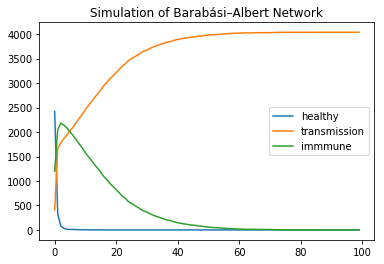

In [4]:
# Barabási Albert network
RealRecords = plot_simulation(social_network(name ="ba",alpha=0.1,beta=0.3), iteration_num = 100)